Code based on the example at https://github.com/kach/gradient-descent-the-ultimate-optimizer

### Comparison of SGD-SGD with SGDExp-SGD

SGD-SGD:  Optimizer from the paper by Chandra et al (https://arxiv.org/abs/1909.13371).  
SGDExp-SGD: Addition of an exponential link function for the adaptive learning rate.

We observed that training is much easier with SGDExp-SGD because it is less crucially dependent on a good hyper-learning rate. The goal of this notebook is to illustrate this by comparing training of a simple model on the MNIST dataset with both optimizers, with multiple hyper-learning rates each time.

If you want to run this notebook on Colab, change the variable in the next cell to True. You might also need to pip install gradient-descent-the-ultimate-optimizer (see link above for more details).

In [5]:
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from gradient_descent_the_ultimate_optimizer import gdtuo
COLAB=False

In [6]:
SAVEPATH='stability-data/'
PREFIX='' #'CIFAR10' for CIFAR10, '' for MNIST
if COLAB:
  from google.colab import drive
  SAVEPATH = '/content/drive/MyDrive/Colab Notebooks/' + SAVEPATH
  drive.mount('/content/drive/')

In [7]:
def save_training_data(train_loss, test_acc, test_loss, name):
  torch.save(train_loss, SAVEPATH+PREFIX+name+"-train-loss.pth")
  torch.save(test_acc, SAVEPATH+PREFIX+name+"-test-acc.pth")
  torch.save(test_loss, SAVEPATH+PREFIX+name+"-test-loss.pth")

def load_training_data(name):
  train_loss = torch.load(SAVEPATH+PREFIX+name+"-train-loss.pth")
  test_acc = torch.load(SAVEPATH+PREFIX+name+"-test-acc.pth")
  test_loss = torch.load(SAVEPATH+PREFIX+name+"-test-loss.pth")
  return train_loss, test_acc, test_loss

In [8]:
#Code adapted from gdtuo implementation of SGD
class SGDExp(gdtuo.Optimizable):
    '''
    A hyperoptimizable SGD.
    '''
    def __init__(self, alpha=0.01, mu=0.0, optimizer=gdtuo.NoOpOptimizer(), exp=False):
        self.mu = mu
        self.state = {}
        self.exp = exp
        parameters = {
            'alpha': torch.tensor(alpha),
            'mu': torch.tensor(mu)
        }
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if self.mu != 0.0:
                if name not in self.state:
                    buf = self.state[name] = g
                else:
                    buf = self.state[name].detach()
                    buf = buf * self.parameters['mu'] + g
                g = self.state[name] = buf
            if self.exp:
              params[name] = p - g * self.parameters['alpha'].exp()
            else:
              params[name] = p - g * self.parameters['alpha']

    def __str__(self):
        return 'sgd / '+ str(self.optimizer)

In [9]:
#Have a different learning rate for each layer
class SGDLayerWise(gdtuo.Optimizable):
    '''
    Optimizes parameters with SGD using one learning rate per parameter tensor.
    '''
    def __init__(self, params, lr0=0.1, optimizer=gdtuo.NoOpOptimizer(), device='cpu'):
        parameters = {k + '_alpha' : torch.tensor([lr0], requires_grad=True).to(device) for k, v in params}
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if name + '_alpha' not in self.parameters: params[name] = p
            else: params[name] = p - g * self.parameters[name + '_alpha'].exp()

    def __str__(self):
        return 'SGDLayerWise / ' + str(self.optimizer)

In [10]:
class SGDParamWise(gdtuo.Optimizable):
    '''
    Optimizes parameters with SGD using one learning rate per parameter
    (effectively doubles the number of learnable parameters).
    '''
    def __init__(self, params, lr0=0.1, optimizer=gdtuo.NoOpOptimizer(), device='cpu'):
        parameters = {k + '_alpha' : lr0 * torch.ones_like(v).to(device)
                      for k, v in params}
        super().__init__(parameters, optimizer)

    def step(self, params):
        self.optimizer.step(self.parameters)
        for name, param in params.items():
            g = param.grad.detach()
            p = param.detach()
            if name + '_alpha' not in self.parameters: params[name] = p
            else: params[name] = p - g * self.parameters[name + '_alpha'].exp()

    def __str__(self):
        return 'SGDLayerWise / ' + str(self.optimizer)

In [12]:
##############################
## MNIST Model + Data
##############################

class MNIST_FullyConnected(nn.Module):
    """
    A fully-connected NN for the MNIST task. This is Optimizable but not itself
    an optimizer.
    """
    def __init__(self, num_inp, num_hid, num_hid2, num_hid3, num_out):
        super(MNIST_FullyConnected, self).__init__()
        self.layer1 = nn.Linear(num_inp, num_hid)
        self.layer2 = nn.Linear(num_hid, num_hid2)
        self.layer3 = nn.Linear(num_hid2, num_hid3)
        self.layer4 = nn.Linear(num_hid3, num_out)


    def initialize(self):
        nn.init.kaiming_uniform_(self.layer1.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer2.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer3.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.layer4.weight, a=math.sqrt(5))

    def forward(self, x):
        """Compute a prediction."""
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.layer3(x)
        x = torch.tanh(x)
        x = self.layer4(x)
        x = F.log_softmax(x, dim=1)
        return x

BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)


In [27]:
##############################
## CIFAR10 Model + Data
##############################

#If you want to use MNIST like we did, you can ignore this cell.

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.channels = channels

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    return y + x

class CIFAR10_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24)
    self.pooling1 = nn.MaxPool2d(2) #Nx24x16x16
    self.res2 = ResidualBlock(24)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)

#Load and transform data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

BATCH_SIZE = 256
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


In [13]:
#Test the model
def test(mw):
  with torch.no_grad():
      for features, labels in dl_test:
          if PREFIX=='': #MNIST
            features, labels = torch.reshape(features, (-1, 28 * 28)).to(DEVICE), labels.to(DEVICE)
          else: #CIFAR10
            features, labels = features.to(DEVICE), labels.to(DEVICE)
          pred = mw.forward(features)
          loss = F.nll_loss(pred, labels, reduction='sum')
          pred = torch.argmax(pred, dim=1)
          print("TEST ACCURACY: {}".format((pred == labels).sum().item() / len(labels)))
          break
  return (pred == labels).sum().item() / len(labels), loss / len(labels)

In [16]:
#Training loop
def train(mw, record_data=False):
  #Store data about the training progress
  train_losses = []
  test_acc = []
  test_loss = []

  for i in range(1, EPOCHS+1):
      running_loss = 0.0
      for n, v in mw.optimizer.parameters.items():
          print(f"Learning rates : {n} : mean={v.mean().item()}, std={v.std().item()}, \
          min={v.min().item()}, max={v.max().item()}")
      for j, (features, labels) in enumerate(dl_train):
          mw.begin() # call this before each step, enables gradient tracking on desired params
          if PREFIX=='':
            features, labels = torch.reshape(features, (-1, 28 * 28)).to(DEVICE), labels.to(DEVICE)
          else:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
          pred = mw.forward(features)
          loss = F.nll_loss(pred, labels)
          mw.zero_grad()
          loss.backward(create_graph=True) # important! use create_graph=True
          mw.step()

          running_loss += loss.item() * features.size(0)
          if record_data:
            train_losses.append(loss.item())


      train_loss = running_loss / len(dl_train.dataset)

      print("EPOCH: {}, TRAIN LOSS: {}".format(i, train_loss))
      if record_data:
        acc, l = test(mw)
        test_acc.append(acc)
        test_loss.append(l.item())
  return train_losses, test_acc, test_loss

In [27]:
#Train the model from scratch with 4 different hyper-learning rates, using our version with exp.
for hyper_lr in [0.1, 0.01, 0.001, 0.0001]:
    model_exp = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)

    #Create the optimizer
    optim_exp = SGDExp(alpha=-1.0, exp=True, optimizer=gdtuo.SGD(hyper_lr))
    mw_exp = gdtuo.ModuleWrapper(model_exp, optimizer=optim_exp)
    mw_exp.initialize()

    train_loss, test_acc, test_loss = train(mw_exp, record_data=True)
    save_training_data(train_loss, test_acc, test_loss, "SGDExp-SGD"+str(math.log10(hyper_lr)))

Learning rates : alpha : mean=-1.0, std=nan,           min=-1.0, max=-1.0
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 1, TRAIN LOSS: 0.7973761243979136
TEST ACCURACY: 0.8901
Learning rates : alpha : mean=-1.2365007400512695, std=nan,           min=-1.2365007400512695, max=-1.2365007400512695
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 0.2927820769627889
TEST ACCURACY: 0.9156
Learning rates : alpha : mean=-1.3461381196975708, std=nan,           min=-1.3461381196975708, max=-1.3461381196975708
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 0.2179051695028941
TEST ACCURACY: 0.9359
Learning rates : alpha : mean=-1.4445818662643433, std=nan,           min=-1.4445818662643433, max=-1.4445818662643433
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 0.17310763271252314
TEST ACCURACY: 0.9493
Learning rates : alpha : mean=-1.51468658447

In [25]:
#Train the model from scratch with 4 different hyper-learning rates, using the version without exp.
for hyper_lr in [0.1, 0.01, 0.001, 0.0001]:
    model = MNIST_FullyConnected(28 * 28, 128, 16, 16, 10).to(DEVICE)

    #Create the optimizer
    #optim = gdtuo.SGD(alpha=0.1, optimizer=gdtuo.NoOpOptimizer())
    optim = gdtuo.SGD(alpha=math.exp(-1.0), optimizer=gdtuo.SGD(hyper_lr))
    mw = gdtuo.ModuleWrapper(model, optimizer=optim)
    mw.initialize()

    train_loss, test_acc, test_loss = train(mw, record_data=True)
    save_training_data(train_loss, test_acc, test_loss, "SGD-SGD"+str(math.log10(hyper_lr)))

Learning rates : alpha : mean=0.3678794503211975, std=nan,           min=0.3678794503211975, max=0.3678794503211975
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 1, TRAIN LOSS: 0.8729928208986918
TEST ACCURACY: 0.8643
Learning rates : alpha : mean=0.03693600744009018, std=nan,           min=0.03693600744009018, max=0.03693600744009018
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 2, TRAIN LOSS: 0.5161532513777415
TEST ACCURACY: 0.8831
Learning rates : alpha : mean=0.01783103682100773, std=nan,           min=0.01783103682100773, max=0.01783103682100773
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 3, TRAIN LOSS: 0.4524363925615946
TEST ACCURACY: 0.8934
Learning rates : alpha : mean=0.024861887097358704, std=nan,           min=0.024861887097358704, max=0.024861887097358704
Learning rates : mu : mean=0.0, std=nan,           min=0.0, max=0.0
EPOCH: 4, TRAIN LOSS: 0.4225876220544179
TEST ACCURACY: 0.8981


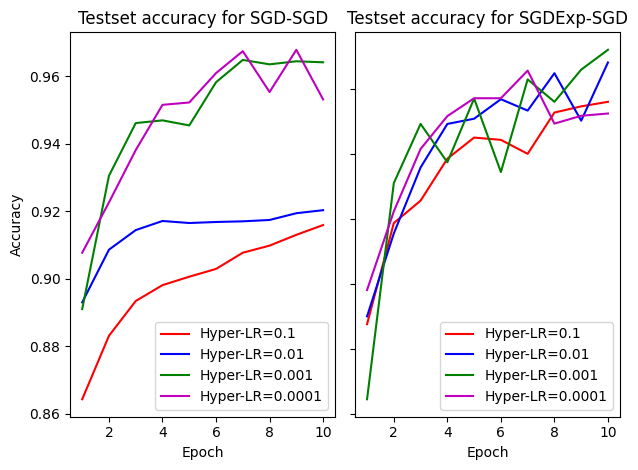

In [37]:
#Plot the testset acc side by side for SGD and SGDExp
fig, axs = plt.subplots(1, 2)
axs[0].set_title("Testset accuracy for SGD-SGD")
axs[1].set_title("Testset accuracy for SGDExp-SGD")
labels = ["0.1", "0.01", "0.001", "0.0001"]
for n, c, label in zip(["SGD-SGD-1.0", "SGD-SGD-2.0", "SGD-SGD-3.0", "SGD-SGD-4.0"], ['r', 'b', 'g', 'm'], labels):
  _, a, _ = load_training_data(n)
  axs[0].plot(range(1, len(a)+1), a, color=c, label="Hyper-LR="+label)

for n, c, label in zip(["SGDExp-SGD-1.0", "SGDExp-SGD-2.0", "SGDExp-SGD-3.0", "SGDExp-SGD-4.0"], ['r', 'b', 'g', 'm'], labels):
  _, a, _ = load_training_data(n)
  axs[1].plot(range(1, len(a)+1), a, color=c, label="Hyper-LR="+label)

for ax in axs.flatten():
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  ax.label_outer()
  ax.legend()

fig.tight_layout()
plt.show()
